# Text classification with an RNN

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [6]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [7]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [8]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [9]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [10]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [11]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'I purchased this film on the cheap in a sale, having read the back of the DVD case and assuming that either way I can\'t lose, it if was rubbish then no loss, if it was any good then bargain...<br /><br />Then I watched it...<br /><br />I am normally a fan of Christopher Walken, but in this film he commanded very little screen presence, seeming not to do a whole lot, even the death of his friend near the beginning which sparks off the "action" in the plot seems to affect him very little, and his eventual revenge is just boring and undramatic.<br /><br />Normally a film which has themes as grand as revolution and revenge are able to capture the audience and snare them into feeling something for the characters, however watching this film felt more like seeing a series of confused, and almost random events that loosely tied together towards it\'s eventual conclusion...<br /><br />At this point I wept...<br /><br />I thought this film was the most horribly painful piece of viewi

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [12]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [13]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [14]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,   1,  11, ...,   0,   0,   0],
       [ 59,  12,  52, ...,   0,   0,   0],
       [ 53, 162,   1, ...,   0,   0,   0]], dtype=int64)

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [15]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I purchased this film on the cheap in a sale, having read the back of the DVD case and assuming that either way I can\'t lose, it if was rubbish then no loss, if it was any good then bargain...<br /><br />Then I watched it...<br /><br />I am normally a fan of Christopher Walken, but in this film he commanded very little screen presence, seeming not to do a whole lot, even the death of his friend near the beginning which sparks off the "action" in the plot seems to affect him very little, and his eventual revenge is just boring and undramatic.<br /><br />Normally a film which has themes as grand as revolution and revenge are able to capture the audience and snare them into feeling something for the characters, however watching this film felt more like seeing a series of confused, and almost random events that loosely tied together towards it\'s eventual conclusion...<br /><br />At this point I wept...<br /><br />I thought this film was the most horribly painful piece of vie

## Train the model

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [16]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [18]:
history = model.fit(train_dataset, epochs=20,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/20
391/391 [==============================] - 100s 206ms/step - loss: 0.6784 - accuracy: 0.5171 - val_loss: 0.4493 - val_accuracy: 0.7823
Epoch 2/20
391/391 [==============================] - 85s 216ms/step - loss: 0.4132 - accuracy: 0.8183 - val_loss: 0.3672 - val_accuracy: 0.8260
Epoch 3/20
391/391 [==============================] - 74s 190ms/step - loss: 0.3498 - accuracy: 0.8515 - val_loss: 0.3484 - val_accuracy: 0.8307
Epoch 4/20
391/391 [==============================] - 65s 165ms/step - loss: 0.3338 - accuracy: 0.8537 - val_loss: 0.3304 - val_accuracy: 0.8474
Epoch 5/20
391/391 [==============================] - 67s 171ms/step - loss: 0.3146 - accuracy: 0.8654 - val_loss: 0.3240 - val_accuracy: 0.8505
Epoch 6/20
391/391 [==============================] - 67s 171ms/step - loss: 0.3111 - accuracy: 0.8697 - val_loss: 0.3320 - val_accuracy: 0.8646
Epoch 7/20
391/391 [==============================] - 67s 171ms/step - loss: 0.3044 - accuracy: 0.8722 - val_loss: 0.3382 - val_a

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

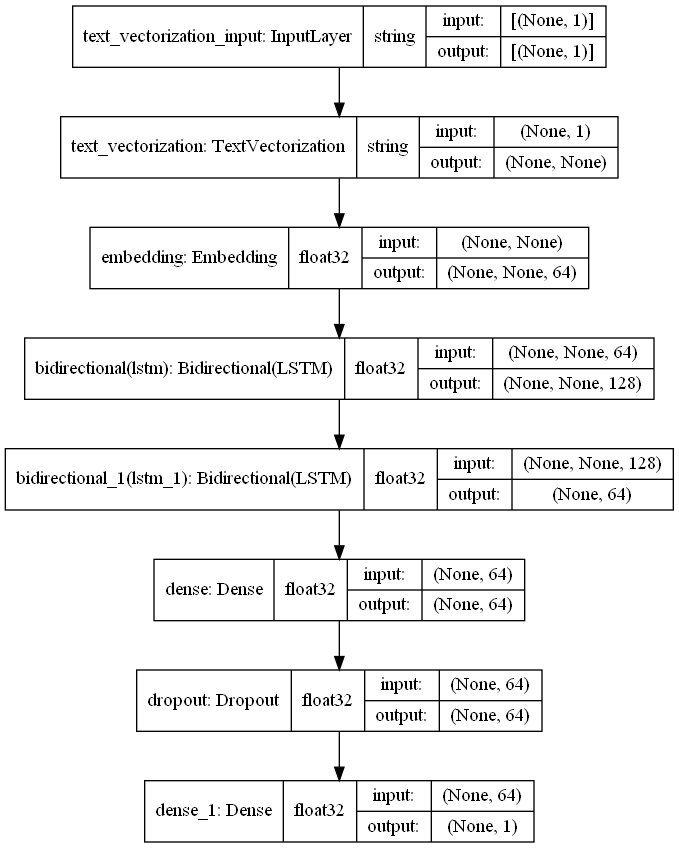

In [22]:
import keras
keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [28]:
!pip install -q pyyaml h5py

In [23]:
!mkdir saved_model

In [24]:
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [37]:
# my_model directory
!ls saved_model

my_model


In [39]:
# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

assets	saved_model.pb	variables


In [2]:
new_model = tf.keras.models.load_model('saved_model/my_model')

In [4]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/my_model')
tflite_model = converter.convert()

In [5]:
open ("text_classification_v2.tflite" , "wb").write(tfmodel)

In [41]:
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = new_model.predict(np.array([sample_text]))
print(predictions)

[[-2.3772874]]


In [42]:
test_loss, test_acc = new_model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 90s 217ms/step - loss: 0.3274 - accuracy: 0.8517
Test Loss: 0.32740336656570435
Test Accuracy: 0.8516799807548523


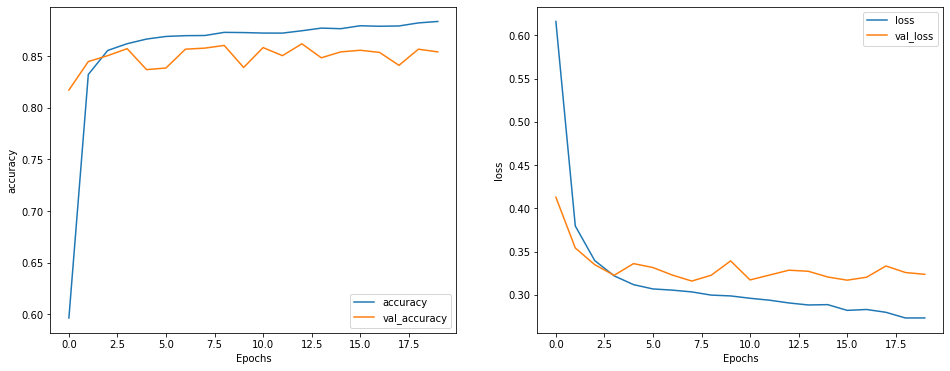

In [43]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')